In [138]:
import os
import re
import spotipy
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import os
import re
import sys
import json

# warnings.filterwarnings("ignore")

In [141]:
# Credentials
os.environ["SPOTIPY_CLIENT_ID"] = "e93bb9b7b8aa4ba8a817537a0f7696f8"
os.environ["SPOTIPY_CLIENT_SECRET"] = "bd54ecc86e3b4bc08b33f3bed6e89dee"
os.environ['SPOTIPY_REDIRECT_URI'] = "http://localhost:8080"   # Needed for user authorization

# Defining scope to read user playlist and write playlist to user
scope = 'user-library-read user-follow-read playlist-modify-private playlist-modify'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [113]:
df = pd.read_csv('data/Playlist_Feats.csv')
df.head()

,name,pid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Throwbacks,0,0.664077,0.781077,5.038462,-4.891212,0.692308,0.103698,0.083674,0.000674,0.187087,0.642750,121.157500,221777.461538,4.000000
1,Awesome Playlist,1,0.492382,0.695923,4.461538,-8.107974,0.538462,0.091010,0.162227,0.223708,0.179344,0.476667,124.987128,298837.641026,3.769231
2,korean,2,0.671062,0.692953,5.000000,-4.875594,0.515625,0.096425,0.269100,0.000638,0.168894,0.565078,114.595984,219373.953125,4.000000
3,mat,3,0.514349,0.620901,5.103175,-9.618754,0.714286,0.067004,0.273514,0.203148,0.188278,0.451258,125.523048,229575.055556,3.952381
4,90s,4,0.576235,0.650418,3.352941,-7.634529,0.823529,0.041218,0.177189,0.081759,0.166524,0.490294,127.725412,255014.352941,3.941176


In [7]:
# Get all favorite songs from current user and save them to lists to construct dataframe
tracks = sp.current_user_saved_tracks()

song = []
artist = []
uri = []

#First pass of the saved tracks
for i in tracks['items']:
    song.append(i['track']['name'])
    artist.append(i['track']['artists'][0]['name'])
    uri_id = i['track']['uri']
    uri.append(re.search('(^spotify:track:([^\s]+))', uri_id).groups()[1])

# Keep looking in tracks for the rest of the saved tracks, they are paginated
while tracks['next']:
    tracks = sp.next(tracks)
    for i in tracks['items']:
        song.append(i['track']['name'])
        artist.append(i['track']['artists'][0]['name'])
        uri_id = i['track']['uri']
        uri.append(re.search('(^spotify:track:([^\s]+))', uri_id).groups()[1])

# Create a dataframe from info extracted above, song, artist and uri
fav_songs_df = pd.DataFrame(
    {'song': song,
     'artist': artist,
     'uri': uri
    })
fav_songs_df.head()

In [9]:
# Extract audio features from each song and create a dataframe
appended_df = []
for i in uri:
    appended_df.append(pd.DataFrame(sp.audio_features(i)[0], index=[i,]))
uri_df = pd.concat(appended_df)
uri_df = uri_df.drop(['uri'], axis=1)
uri_df = uri_df.reset_index()
uri_df = uri_df.rename(columns={"index": "uri"})

fav_songs_feats_df = pd.merge(fav_songs_df, uri_df, on="uri")
fav_songs_feats_df.head()

In [114]:
feat_cols = ['pid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
feat_cols_user = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

# Playlists as Features

In [80]:
X.T

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
pid,,,,,,,,,,,,,
0,0.664077,0.781077,5.038462,-4.891212,0.692308,0.103698,0.083674,0.000674,0.187087,0.642750,121.157500,221777.461538,4.000000
1,0.492382,0.695923,4.461538,-8.107974,0.538462,0.091010,0.162227,0.223708,0.179344,0.476667,124.987128,298837.641026,3.769231
2,0.671062,0.692953,5.000000,-4.875594,0.515625,0.096425,0.269100,0.000638,0.168894,0.565078,114.595984,219373.953125,4.000000
3,0.514349,0.620901,5.103175,-9.618754,0.714286,0.067004,0.273514,0.203148,0.188278,0.451258,125.523048,229575.055556,3.952381
4,0.576235,0.650418,3.352941,-7.634529,0.823529,0.041218,0.177189,0.081759,0.166524,0.490294,127.725412,255014.352941,3.941176
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100544,0.566682,0.762841,6.431818,-4.805636,0.772727,0.046709,0.151873,0.005868,0.189711,0.567523,130.645159,207862.977273,4.000000
100545,0.796475,0.615541,5.327869,-6.091721,0.590164,0.177521,0.140642,0.005669,0.157311,0.431108,120.764672,227009.131148,3.983607
100546,0.516377,0.772157,4.937107,-5.105491,0.672956,0.069122,0.089348,0.030825,0.180323,0.408645,130.369283,239304.553459,3.987421


In [86]:
pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,...,3539,3540,3541,3542,3543,3544,3545,3546,3547,3548
0,-0.577773,-0.577673,-0.577752,-0.577772,-0.577737,-0.577743,-0.577798,-0.577739,-0.577816,-0.577811,...,-0.577729,-0.577770,-0.577748,-0.577597,-0.577811,-0.577836,-0.577761,-0.577771,-0.577735,-0.577796
1,1.732051,1.732051,1.732051,1.732051,1.732051,1.732051,1.732051,1.732051,1.732051,1.732051,...,1.732051,1.732051,1.732051,1.732051,1.732051,1.732051,1.732051,1.732051,1.732051,1.732051
2,-0.577766,-0.577670,-0.577750,-0.577767,-0.577731,-0.577737,-0.577790,-0.577739,-0.577810,-0.577806,...,-0.577727,-0.577771,-0.577746,-0.577597,-0.577806,-0.577829,-0.577756,-0.577766,-0.577733,-0.577793
3,-0.576512,-0.576708,-0.576549,-0.576512,-0.576582,-0.576571,-0.576463,-0.576572,-0.576424,-0.576434,...,-0.576595,-0.576510,-0.576556,-0.576857,-0.576433,-0.576386,-0.576533,-0.576514,-0.576582,-0.576461


In [84]:
y_test

acousticness         0.206547
duration_ms     231229.150928
mode                 0.648910
tempo              121.815843
dtype: float64

In [46]:
# Transpose df to have playlists as features - This is going to be X
X = df[feat_cols].set_index('pid').T
# Mean of the features of the user's fav songs - This is going to be y
y = fav_songs_feats_df[feat_cols_user].mean()

# Split data for training and testing
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state=0)

X_train = StandardScaler().fit_transform(X_train_raw)
X_test  = StandardScaler().fit_transform(X_test_raw)

In [65]:
# Dummy classifiers to check against real classifier
dummy_A = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
dummy_B = DummyRegressor(strategy = 'median').fit(X_train, y_train)

y_dummy_A_predictions = dummy_A.predict(X_test)
y_dummy_B_predictions = dummy_B.predict(X_test)

R2_A = dummy_A.score(X_test, y_test)
RMSE_A = mean_squared_error(y_test, y_dummy_A_predictions, squared=False)
MAE_A = mean_absolute_error(y_test, y_dummy_A_predictions)

R2_B = dummy_A.score(X_test, y_test)
RMSE_B = mean_squared_error(y_test, y_dummy_B_predictions, squared=False)
MAE_B = mean_absolute_error(y_test, y_dummy_A_predictions)

print('Dummy Regressor A Scores (Mean)')
print('R2: {}'.format(R2_A))
print('RMSE:    {}'.format(RMSE_A))
print('MAE:  {}\n'.format(MAE_A))

print('Dummy Regressor B Scores (Median)')
print('R2: {}'.format(R2_B))
print('RMSE:    {}'.format(RMSE_B))
print('MAE:  {}'.format(MAE_B))

Dummy Regressor A Scores (Mean)
R2: -0.33379879043333927
RMSE:    115614.31919372884
MAE:  57837.58011264492

Dummy Regressor B Scores (Median)
R2: -0.33379879043333927
RMSE:    115614.30693666621
MAE:  57837.58011264492


In [ ]:
models = [LinearRegression(), Lasso()]

In [89]:
reg = LinearRegression().fit(X, y)
print(reg)
print('R2: {}'.format((reg.score(X, y))))
y_pred = reg.predict(X)
print('RMSE: {}'.format(mean_squared_error(y, y_pred, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y, y_pred)))

importance = reg.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

LinearRegression()
R2: 1.0
RMSE: 1.238143231877954e-10
MAE: 5.835397016023663e-11
Feature: 0, Score: -0.01657
Feature: 1, Score: 0.00031
Feature: 2, Score: 0.00074
Feature: 3, Score: 0.00015
Feature: 4, Score: 0.00049
Feature: 5, Score: 0.00058
Feature: 6, Score: 0.00034
Feature: 7, Score: 0.00068
Feature: 8, Score: 0.00026
Feature: 9, Score: 0.00050
Feature: 10, Score: -0.00000
Feature: 11, Score: 0.00051
Feature: 12, Score: 0.00039
Feature: 13, Score: -0.00006
Feature: 14, Score: 0.00024
Feature: 15, Score: 0.00082
Feature: 16, Score: 0.00031
Feature: 17, Score: 0.00055
Feature: 18, Score: 0.00038
Feature: 19, Score: 0.00030
Feature: 20, Score: -0.00016
Feature: 21, Score: 0.00012
Feature: 22, Score: 0.00042
Feature: 23, Score: 0.00018
Feature: 24, Score: 0.00016
Feature: 25, Score: 0.00071
Feature: 26, Score: 0.00034
Feature: 27, Score: 0.00030
Feature: 28, Score: 0.00002
Feature: 29, Score: 0.00046
Feature: 30, Score: 0.00002
Feature: 31, Score: 0.00076
Feature: 32, Score: 0.00051


Feature: 1270, Score: 0.00044
Feature: 1271, Score: 0.00098
Feature: 1272, Score: 0.00030
Feature: 1273, Score: 0.00044
Feature: 1274, Score: 0.00091
Feature: 1275, Score: -0.00017
Feature: 1276, Score: 0.00036
Feature: 1277, Score: 0.00000
Feature: 1278, Score: 0.00050
Feature: 1279, Score: 0.00030
Feature: 1280, Score: 0.00058
Feature: 1281, Score: 0.00045
Feature: 1282, Score: 0.00050
Feature: 1283, Score: 0.00026
Feature: 1284, Score: 0.00053
Feature: 1285, Score: -0.00006
Feature: 1286, Score: 0.00101
Feature: 1287, Score: 0.00044
Feature: 1288, Score: 0.00034
Feature: 1289, Score: 0.00027
Feature: 1290, Score: 0.00059
Feature: 1291, Score: 0.00075
Feature: 1292, Score: 0.00008
Feature: 1293, Score: 0.00084
Feature: 1294, Score: 0.00062
Feature: 1295, Score: 0.00015
Feature: 1296, Score: 0.00040
Feature: 1297, Score: 0.00043
Feature: 1298, Score: 0.00051
Feature: 1299, Score: 0.00035
Feature: 1300, Score: 0.00040
Feature: 1301, Score: -0.00006
Feature: 1302, Score: 0.00068
Feature

Feature: 2270, Score: 0.00019
Feature: 2271, Score: 0.00033
Feature: 2272, Score: -0.00057
Feature: 2273, Score: 0.00029
Feature: 2274, Score: 0.00048
Feature: 2275, Score: 0.00060
Feature: 2276, Score: -0.00003
Feature: 2277, Score: -0.00031
Feature: 2278, Score: -0.00031
Feature: 2279, Score: 0.00022
Feature: 2280, Score: -0.00001
Feature: 2281, Score: 0.00034
Feature: 2282, Score: 0.00006
Feature: 2283, Score: -0.00040
Feature: 2284, Score: 0.00065
Feature: 2285, Score: -0.00053
Feature: 2286, Score: 0.00062
Feature: 2287, Score: 0.00043
Feature: 2288, Score: 0.00023
Feature: 2289, Score: -0.00031
Feature: 2290, Score: 0.00046
Feature: 2291, Score: 0.00005
Feature: 2292, Score: 0.00014
Feature: 2293, Score: 0.00027
Feature: 2294, Score: 0.00030
Feature: 2295, Score: 0.00046
Feature: 2296, Score: 0.00023
Feature: 2297, Score: 0.00050
Feature: 2298, Score: -0.00005
Feature: 2299, Score: 0.00027
Feature: 2300, Score: 0.00077
Feature: 2301, Score: 0.00004
Feature: 2302, Score: 0.00014
F

Feature: 3269, Score: -0.00019
Feature: 3270, Score: 0.00050
Feature: 3271, Score: -0.00076
Feature: 3272, Score: -0.00010
Feature: 3273, Score: 0.00029
Feature: 3274, Score: 0.00072
Feature: 3275, Score: 0.00042
Feature: 3276, Score: 0.00019
Feature: 3277, Score: 0.00058
Feature: 3278, Score: 0.00025
Feature: 3279, Score: 0.00023
Feature: 3280, Score: 0.00033
Feature: 3281, Score: 0.00042
Feature: 3282, Score: 0.00024
Feature: 3283, Score: 0.00006
Feature: 3284, Score: 0.00055
Feature: 3285, Score: -0.00020
Feature: 3286, Score: 0.00017
Feature: 3287, Score: 0.00041
Feature: 3288, Score: 0.00022
Feature: 3289, Score: 0.00101
Feature: 3290, Score: 0.00039
Feature: 3291, Score: 0.00068
Feature: 3292, Score: -0.00036
Feature: 3293, Score: 0.00035
Feature: 3294, Score: 0.00001
Feature: 3295, Score: 0.00015
Feature: 3296, Score: 0.00041
Feature: 3297, Score: 0.00017
Feature: 3298, Score: -0.00022
Feature: 3299, Score: 0.00017
Feature: 3300, Score: 0.00069
Feature: 3301, Score: 0.00019
Feat

In [101]:
from sklearn.ensemble.forest import RandomForestRegressor
# Can combine step above with this
forest = RandomForestRegressor(random_state=42, max_depth=5, max_features=10) 
forest.fit(X,y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature rankings
print("Playlist ranking:")
  
for f in range(len(importances)):
    print("%d. %s %f " % (f + 1, 
            X.columns[f], 
            importances[indices[f]]))

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


Playlist ranking:
1. 0 0.019978 
2. 1 0.019850 
3. 2 0.010021 
4. 3 0.010000 
5. 4 0.010000 
6. 5 0.010000 
7. 6 0.010000 
8. 7 0.010000 
9. 8 0.010000 
10. 9 0.010000 
11. 10 0.010000 
12. 11 0.010000 
13. 12 0.010000 
14. 13 0.010000 
15. 14 0.010000 
16. 15 0.010000 
17. 16 0.010000 
18. 17 0.010000 
19. 18 0.010000 
20. 19 0.010000 
21. 20 0.010000 
22. 21 0.010000 
23. 22 0.010000 
24. 23 0.010000 
25. 24 0.010000 
26. 25 0.010000 
27. 26 0.010000 
28. 27 0.010000 
29. 28 0.010000 
30. 29 0.010000 
31. 30 0.010000 
32. 31 0.010000 
33. 32 0.010000 
34. 33 0.010000 
35. 34 0.010000 
36. 35 0.010000 
37. 36 0.010000 
38. 37 0.010000 
39. 38 0.010000 
40. 39 0.010000 
41. 40 0.010000 
42. 41 0.010000 
43. 42 0.010000 
44. 43 0.010000 
45. 44 0.010000 
46. 45 0.010000 
47. 46 0.010000 
48. 47 0.010000 
49. 48 0.010000 
50. 49 0.010000 
51. 50 0.010000 
52. 51 0.010000 
53. 52 0.010000 
54. 53 0.010000 
55. 54 0.010000 
56. 55 0.010000 
57. 56 0.010000 
58. 57 0.010000 
59. 58 0.010000

1632. 1631 0.000000 
1633. 1632 0.000000 
1634. 1633 0.000000 
1635. 1634 0.000000 
1636. 1635 0.000000 
1637. 1636 0.000000 
1638. 1637 0.000000 
1639. 1638 0.000000 
1640. 1639 0.000000 
1641. 1640 0.000000 
1642. 1641 0.000000 
1643. 1642 0.000000 
1644. 1643 0.000000 
1645. 1644 0.000000 
1646. 1645 0.000000 
1647. 1646 0.000000 
1648. 1647 0.000000 
1649. 1648 0.000000 
1650. 1649 0.000000 
1651. 1650 0.000000 
1652. 1651 0.000000 
1653. 1652 0.000000 
1654. 1653 0.000000 
1655. 1654 0.000000 
1656. 1655 0.000000 
1657. 1656 0.000000 
1658. 1657 0.000000 
1659. 1658 0.000000 
1660. 1659 0.000000 
1661. 1660 0.000000 
1662. 1661 0.000000 
1663. 1662 0.000000 
1664. 1663 0.000000 
1665. 1664 0.000000 
1666. 1665 0.000000 
1667. 1666 0.000000 
1668. 1667 0.000000 
1669. 1668 0.000000 
1670. 1669 0.000000 
1671. 1670 0.000000 
1672. 1671 0.000000 
1673. 1672 0.000000 
1674. 1673 0.000000 
1675. 1674 0.000000 
1676. 1675 0.000000 
1677. 1676 0.000000 
1678. 1677 0.000000 
1679. 1678 0.

2340. 10339 0.000000 
2341. 10340 0.000000 
2342. 10341 0.000000 
2343. 10342 0.000000 
2344. 10343 0.000000 
2345. 10344 0.000000 
2346. 10345 0.000000 
2347. 10346 0.000000 
2348. 10347 0.000000 
2349. 10348 0.000000 
2350. 10349 0.000000 
2351. 10350 0.000000 
2352. 10351 0.000000 
2353. 10352 0.000000 
2354. 10353 0.000000 
2355. 10354 0.000000 
2356. 10355 0.000000 
2357. 10356 0.000000 
2358. 10357 0.000000 
2359. 10358 0.000000 
2360. 10359 0.000000 
2361. 10360 0.000000 
2362. 10361 0.000000 
2363. 10362 0.000000 
2364. 10363 0.000000 
2365. 10364 0.000000 
2366. 10365 0.000000 
2367. 10366 0.000000 
2368. 10367 0.000000 
2369. 10368 0.000000 
2370. 10369 0.000000 
2371. 10370 0.000000 
2372. 10371 0.000000 
2373. 10372 0.000000 
2374. 10373 0.000000 
2375. 10374 0.000000 
2376. 10375 0.000000 
2377. 10376 0.000000 
2378. 10377 0.000000 
2379. 10378 0.000000 
2380. 10379 0.000000 
2381. 10380 0.000000 
2382. 10381 0.000000 
2383. 10382 0.000000 
2384. 10383 0.000000 
2385. 1038

# Unsupervised Approach

In [11]:
df.head()

,name,pid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Throwbacks,0,0.664077,0.781077,5.038462,-4.891212,0.692308,0.103698,0.083674,0.000674,0.187087,0.642750,121.157500,221777.461538,4.000000
1,Awesome Playlist,1,0.492382,0.695923,4.461538,-8.107974,0.538462,0.091010,0.162227,0.223708,0.179344,0.476667,124.987128,298837.641026,3.769231
2,korean,2,0.671062,0.692953,5.000000,-4.875594,0.515625,0.096425,0.269100,0.000638,0.168894,0.565078,114.595984,219373.953125,4.000000
3,mat,3,0.514349,0.620901,5.103175,-9.618754,0.714286,0.067004,0.273514,0.203148,0.188278,0.451258,125.523048,229575.055556,3.952381
4,90s,4,0.576235,0.650418,3.352941,-7.634529,0.823529,0.041218,0.177189,0.081759,0.166524,0.490294,127.725412,255014.352941,3.941176


In [84]:
# feats_df = df[feat_cols_user]
scaler = StandardScaler(with_mean=True, with_std=True).fit(df[feat_cols_user])
scaled_data = scaler.transform(df[feat_cols_user])
scaled_y = scaler.transform(np.array(y).reshape(1,-1))
feats_df = pd.DataFrame(scaled_data)
feats_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.609544,1.086705,-0.194663,0.991172,0.205123,0.188191,-0.913037,-0.474703,-0.007942,1.207127,-0.018214,-0.377364,0.600037
1,-1.166719,0.446851,-1.055715,-0.287980,-0.793176,-0.037243,-0.462322,1.240746,-0.191274,-0.095910,0.498871,1.860080,-1.757273
2,0.681813,0.424534,-0.252066,0.997383,-0.941361,0.058965,0.150882,-0.474984,-0.438699,0.597738,-0.904164,-0.447150,0.600037
3,-0.939458,-0.116874,-0.098079,-0.888745,0.347737,-0.463780,0.176210,1.082607,0.020263,-0.295259,0.571232,-0.150961,0.113608
4,-0.299218,0.104919,-2.710287,-0.099714,1.056613,-0.921944,-0.376476,0.148952,-0.494819,0.011006,0.868600,0.587670,-0.000846


In [21]:
df_tsne = pd.DataFrame(TSNE(n_components = 2, random_state = 0).fit_transform(df[feat_cols_user]),columns=['X','Y']) 
# feats_df
# df[feat_cols_user]
df_tsne.head()

,X,Y
0,53.969749,-41.115440
1,-3.260087,-75.836945
2,88.949699,-20.689274
3,-16.000729,23.201551
4,-61.551140,-3.262611


<AxesSubplot:xlabel='X', ylabel='Y'>

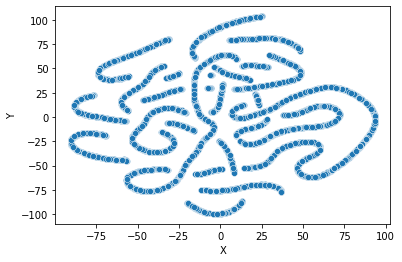

In [22]:
sns.scatterplot(x='X', y='Y', data=df_tsne, legend=None)

In [19]:
def single_model_and_plot(model, K, df, df_clusters, title, random_state=0):
    try:
        clustering = model(n_clusters=K, random_state=random_state).fit(df)
    except TypeError:
        clustering = model(n_clusters=K).fit(df)
    df_clusters['cluster'] = pd.Categorical(clustering.labels_)
    
#     fig = plt.figure(figsize=(10,7))
    
#     plt.subplot(2,2,1)
#     sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_clusters, legend=None)
#     plt.subplot(2,2,2)
    sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_clusters, legend=None)
#     plt.subplot(2,2,3)
#     sns.scatterplot(x='MDS_X', y='MDS_Y', hue='cluster', style='cluster', data=df_clusters, legend=None)

#     gpca.legend(bbox_to_anchor=(1, 1))
#     gtsne.legend(bbox_to_anchor=(1, 1))
#     gmds.legend(bbox_to_anchor=(1, 1))

#     gpca.set_title('PCA')
#     gtsne.set_title('T-SNE')
#     gmds.set_title('MDS')
#     fig.suptitle('{} with {}'.format(title, clustering), fontsize=16)
#     plt.show()

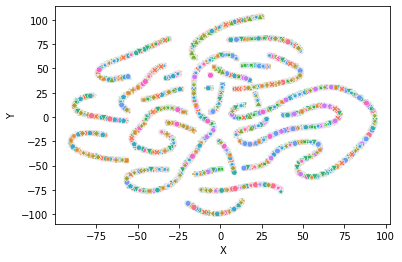

In [229]:
single_model_and_plot(AgglomerativeClustering, K=20, df=scaled_data, df_clusters=df_tsne, 
                      title='Clustering on scaled data', random_state=None)

# Similarity Approach

In [31]:
from sklearn.neighbors import NearestNeighbors

In [86]:
scaled_data
feats_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.609544,1.086705,-0.194663,0.991172,0.205123,0.188191,-0.913037,-0.474703,-0.007942,1.207127,-0.018214,-0.377364,0.600037
1,-1.166719,0.446851,-1.055715,-0.287980,-0.793176,-0.037243,-0.462322,1.240746,-0.191274,-0.095910,0.498871,1.860080,-1.757273
2,0.681813,0.424534,-0.252066,0.997383,-0.941361,0.058965,0.150882,-0.474984,-0.438699,0.597738,-0.904164,-0.447150,0.600037
3,-0.939458,-0.116874,-0.098079,-0.888745,0.347737,-0.463780,0.176210,1.082607,0.020263,-0.295259,0.571232,-0.150961,0.113608
4,-0.299218,0.104919,-2.710287,-0.099714,1.056613,-0.921944,-0.376476,0.148952,-0.494819,0.011006,0.868600,0.587670,-0.000846


# SKLearn Nearest Neighbors

In [147]:
nbrs = NearestNeighbors(n_neighbors=3).fit(scaled_data)
nbrs.kneighbors(scaled_y)
# closest_vec = sacaled_data[nbrs.kneighbors(np.atleast_2d(y))[1][0,0]]
# closest_vec

(array([[0.68474234, 0.7505799 , 0.79766161]]), array([[2078, 3887, 9103]]))

In [89]:
feats_df.loc[[2078]]

,0,1,2,3,4,5,6,7,8,9,10,11,12
2078,0.158655,0.399674,-0.506107,0.306164,-0.366244,-0.331417,-0.380355,-0.013421,0.183518,0.657684,0.215979,-0.37545,0.29576


In [90]:
sacaled_data[2078]

array([ 0.15865471,  0.3996743 , -0.50610716,  0.30616442, -0.36624381,
       -0.33141667, -0.38035524, -0.01342114,  0.18351837,  0.65768389,
        0.21597865, -0.37545046,  0.29576008])

In [91]:
y

danceability             0.641738
energy                   0.707054
key                      5.106538
loudness                -6.428839
mode                     0.648910
speechiness              0.075329
acousticness             0.206547
instrumentalness         0.069421
liveness                 0.190474
valence                  0.568844
tempo                  121.815843
duration_ms         231229.150928
time_signature           3.968523
dtype: float64

In [93]:
df.loc[[2078]]

,name,pid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
2078,Good Feels,10078,0.620494,0.689645,4.829787,-6.613843,0.604255,0.074454,0.176513,0.060648,0.195173,0.572719,122.891974,221843.378723,3.970213


In [97]:
MPD = pd.read_csv('data/MPD.csv')

In [106]:
MPD[MPD['pid']==10078]

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
2078,Good Feels,False,10078,1507593600,235,153,1,"[{'pos': 0, 'artist_name': 'The Weeknd', 'trac...",69,52129256,96,NaN


In [144]:
items = []
for track in playlists[2078]['tracks']:
    items.append(track['track_uri'].split("k:")[1])
items

['6RsWqX8zABZLhZydXxEFOm',
 '4WjH9Bzt3kx7z8kl0awxh4',
 '4hFt8wslsJMahmrTx5uUJM',
 '5b9iBVhfYxDF4JJcHrNIx5',
 '7cgu4JBW3hq1GwTM1ilkKQ',
 '14OxJlLdcHNpgsm4DRwDOB',
 '3VCmztoNt9AMNFnh70na3d',
 '6ubXleMWwmzwmKTBer20PX',
 '5WSL7UTa38jMWoBzObD4BD',
 '3b00LSFIRqnHvkoDEs5fkg',
 '283LAlCpfArRZOXPfkOQj0',
 '2ijYaB3g5jj1TdxQyegiuR',
 '7yq4Qj7cqayVTp3FF9CWbm',
 '0xMd5bcWTbyXS7wPrBtZA6',
 '1kusepF3AacIEtUTYrw4GV',
 '5a7NdkF09AfD0H607eiOkX',
 '5edBgVtRD0fvWk140Sl21T',
 '6D5pfooPP6hi99RaXjkDsP',
 '0LOcXq48Q660WIRrMlhEDP',
 '2MVwrvjmcdt4MsYYLCYMt8',
 '4KVYCdoWmDa4KS1OY6sgMa',
 '5G1sTBGbZT5o4PNRc75RKI',
 '0grFc6klR3hxoHLcgCYsF4',
 '3Hx7RXqCS7Kzjy2ot2q1Gk',
 '5lN1EH25gdiqT1SFALMAq1',
 '2UE4m8egf0aREmOi47sDOk',
 '4HRa9ZWcmZ8JD7UySPu0wT',
 '3zvHOVC4jikl6jORSr6OLE',
 '1cV4DVeAM5AstrDlXgvzJ7',
 '5QldjuXcxplhjjUqLrzl6H',
 '1Zqy9bervYUomy12Pbm3rP',
 '2CzWeyC9zlDpIOZPUUKrBW',
 '4RnCPWlBsY7oUDdyruod7Y',
 '0SuG9kyzGRpDqrCWtgD6Lq',
 '5KL4iZkCTZyXl7KnHgfVDj',
 '6JMZJUyjquUbx3X7tRqMLt',
 '3rxp3uOONxH1onlLzs9kX3',
 

In [142]:
user_id = sp.current_user()['id']
sp.user_playlist_create('1276348384', 'Hello World!')


{'collaborative': False,
 'description': '',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/1ewlC2ss8NLLK59mABtGgF'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/playlists/1ewlC2ss8NLLK59mABtGgF',
 'id': '1ewlC2ss8NLLK59mABtGgF',
 'images': [],
 'name': 'Hello World!',
 'owner': {'display_name': 'David Hernandez',
  'external_urls': {'spotify': 'https://open.spotify.com/user/1276348384'},
  'href': 'https://api.spotify.com/v1/users/1276348384',
  'id': '1276348384',
  'type': 'user',
  'uri': 'spotify:user:1276348384'},
 'primary_color': None,
 'public': True,
 'snapshot_id': 'MSwyOWZkNTBkYWVlMjYyNjliNGE4Y2IyMTg0MWJjMjcyNWQwOTA1NDM4',
 'tracks': {'href': 'https://api.spotify.com/v1/playlists/1ewlC2ss8NLLK59mABtGgF/tracks',
  'items': [],
  'limit': 100,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0},
 'type': 'playlist',
 'uri': 'spotify:playlist:1ewlC2ss8NLLK59mABtGgF'}

In [146]:
sp.playlist_add_items('1ewlC2ss8NLLK59mABtGgF',items=items[:99])

{'snapshot_id': 'Miw1NGYxMjNkNTMxYzU1MmUwYjIwYTFhYTE5ODNkNGVhZTFlODI4Y2I3'}

# Cosine Similarity

In [148]:
from scipy.spatial.distance import cdist

In [ ]:
['cosine', 'euclidian', 'mahalanobis', 'canberra', 'chebyshev']

In [222]:
# Run similarity and select top 3 closests
simi = cdist(scaled_data, scaled_y, metric='cosine').argsort(axis=None)[-1]
simi

5120

In [223]:
df.loc[simi]

name                ~my love 
pid                    102120
danceability         0.540511
energy               0.439174
key                   5.07609
loudness              -8.8177
mode                 0.695652
speechiness           0.10328
acousticness         0.481206
instrumentalness    0.0362831
liveness             0.141576
valence               0.33086
tempo                  117.71
duration_ms            233092
time_signature        3.82609
Name: 5120, dtype: object

In [224]:
playlists[simi]

{'name': '~my love ',
 'collaborative': 'false',
 'pid': 102120,
 'modified_at': 1509321600,
 'num_tracks': 92,
 'num_albums': 74,
 'num_followers': 1,
 'tracks': [{'pos': 0,
   'artist_name': 'Angus & Julia Stone',
   'track_uri': 'spotify:track:75lZuP4E7RTYiVZleLlpFj',
   'artist_uri': 'spotify:artist:4tvKz56Tr39bkhcQUTO0Xr',
   'track_name': 'Draw Your Swords',
   'album_uri': 'spotify:album:0C29hfEJQdcyzpTHy8tTXr',
   'duration_ms': 395600,
   'album_name': 'Down The Way'},
  {'pos': 1,
   'artist_name': 'Angus & Julia Stone',
   'track_uri': 'spotify:track:2fbXJ0VpxhW7j0qcg1DnoZ',
   'artist_uri': 'spotify:artist:4tvKz56Tr39bkhcQUTO0Xr',
   'track_name': 'Big Jet Plane',
   'album_uri': 'spotify:album:0C29hfEJQdcyzpTHy8tTXr',
   'duration_ms': 239120,
   'album_name': 'Down The Way'},
  {'pos': 2,
   'artist_name': 'G-Eazy',
   'track_uri': 'spotify:track:1Bqxj0aH5KewYHKUg1IdrF',
   'artist_uri': 'spotify:artist:02kJSzxNuaWGqwubyUba0Z',
   'track_name': 'Some Kind Of Drug',
   'al

In [180]:
sp.user('1276348384')
sp.user_playlists('1276348384')

{'href': 'https://api.spotify.com/v1/users/1276348384/playlists?offset=0&limit=50',
 'items': [{'collaborative': False,
   'description': '',
   'external_urls': {'spotify': 'https://open.spotify.com/playlist/1ewlC2ss8NLLK59mABtGgF'},
   'href': 'https://api.spotify.com/v1/playlists/1ewlC2ss8NLLK59mABtGgF',
   'id': '1ewlC2ss8NLLK59mABtGgF',
   'images': [{'height': 640,
     'url': 'https://mosaic.scdn.co/640/ab67616d0000b2737a293e6787c6d200c5077cd0ab67616d0000b2737fcead687e99583072cc217bab67616d0000b273954f42ad7b6c8e06c3527497ab67616d0000b273d73966976fd29781c3a8dde0',
     'width': 640},
    {'height': 300,
     'url': 'https://mosaic.scdn.co/300/ab67616d0000b2737a293e6787c6d200c5077cd0ab67616d0000b2737fcead687e99583072cc217bab67616d0000b273954f42ad7b6c8e06c3527497ab67616d0000b273d73966976fd29781c3a8dde0',
     'width': 300},
    {'height': 60,
     'url': 'https://mosaic.scdn.co/60/ab67616d0000b2737a293e6787c6d200c5077cd0ab67616d0000b2737fcead687e99583072cc217bab67616d0000b273954f42

In [179]:
sp.current_user_top_tracks()

HTTP Error for GET to https://api.spotify.com/v1/me/top/tracks returned 403 due to error


SpotifyException: http status: 403, code:-1 - https://api.spotify.com/v1/me/top/tracks?time_range=medium_term&limit=20&offset=0:
 error, reason: None

In [115]:
# Change the path to where your Spotify Million Playlist is located.
# The expected file structure is to have a data folder /data .csv files will be placed there.

path = 'data/spotify_million_playlist_dataset/data'

def loop_slices(path, num_slices=20):
    """
    Each slice is a .json file containing 1000 playlists i.e.: 1 slice is 1000 playlists 20 slices is: 20,000 playlists.
    Parameters:
        num_slices (int): Number of slices to return, max 1000.
        path (str): Path to the Spotify Million Playlist.
        
    Output:
        mpd_playlists (list): a list of dictionaries of all the playlists.
    """
    cnt=0
    mpd_playlists = []
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        print(filename)
        cnt+=1
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            current_slice = json.loads(js)
            
            # Create a list of all playlists
            for playlist in current_slice['playlists']:
                mpd_playlists.append(playlist)


            if cnt == num_slices:
                break
    return mpd_playlists

In [116]:
playlists = loop_slices(path, num_slices=20)



mpd.slice.0-999.json
mpd.slice.1000-1999.json
mpd.slice.10000-10999.json
mpd.slice.100000-100999.json
mpd.slice.101000-101999.json
mpd.slice.102000-102999.json
mpd.slice.103000-103999.json
mpd.slice.104000-104999.json
mpd.slice.105000-105999.json
mpd.slice.106000-106999.json
mpd.slice.107000-107999.json
mpd.slice.108000-108999.json
mpd.slice.109000-109999.json
mpd.slice.11000-11999.json
mpd.slice.110000-110999.json
mpd.slice.111000-111999.json
mpd.slice.112000-112999.json
mpd.slice.113000-113999.json
mpd.slice.114000-114999.json
mpd.slice.115000-115999.json


In [231]:
playlists[1]

{'name': 'Awesome Playlist',
 'collaborative': 'false',
 'pid': 1,
 'modified_at': 1506556800,
 'num_tracks': 39,
 'num_albums': 23,
 'num_followers': 1,
 'tracks': [{'pos': 0,
   'artist_name': 'Survivor',
   'track_uri': 'spotify:track:2HHtWyy5CgaQbC7XSoOb0e',
   'artist_uri': 'spotify:artist:26bcq2nyj5GB7uRr558iQg',
   'track_name': 'Eye of the Tiger',
   'album_uri': 'spotify:album:4PT9VulQaQP6XR1xBI2x1W',
   'duration_ms': 243773,
   'album_name': 'Eye Of The Tiger'},
  {'pos': 1,
   'artist_name': 'Daniel Tidwell',
   'track_uri': 'spotify:track:1MYYt7h6amcrauCOoso3Gx',
   'artist_uri': 'spotify:artist:7zdmbPudNX4SQJXnYIuCTC',
   'track_name': 'Libera Me From Hell (Tengen Toppa Gurren Lagann)',
   'album_uri': 'spotify:album:3q8vR3PFV8kG1m1Iv8DpKq',
   'duration_ms': 70294,
   'album_name': 'Versus Hollywood'},
  {'pos': 2,
   'artist_name': 'Daniel Tidwell',
   'track_uri': 'spotify:track:3x2mJ2bjCIU70NrH49CtYR',
   'artist_uri': 'spotify:artist:7zdmbPudNX4SQJXnYIuCTC',
   'trac

In [ ]:
l1 = [s1, s2, s3]
user = [s3, s2, s5]